In [14]:
import sys
sys.path.append('../')

from FeatureModels import *
from sklearn.ensemble import RandomForestRegressor

In [15]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
%autoreload 2 

In [17]:
sensor = 's'
fill = '_fill'

district = 'Mean'

#savePath = 'Results/Results RF large periods.xlsx'

In [18]:
params = { 
    'n_estimators': np.linspace(10, 1000, 7).round().astype('int'),
    'max_features': np.linspace(0.1, 1, 5)
}
params

{'n_estimators': array([  10,  175,  340,  505,  670,  835, 1000]),
 'max_features': array([0.1  , 0.325, 0.55 , 0.775, 1.   ])}

## Модели, обученные за года

In [19]:
model = RandomForestRegressor(random_state = 100)

Пропуски в Wind_dir : 1
Пропуски в Wind_speed : 1


,Train,CV,Test
"2019-01-01 — 2023-03-22 {'max_features': 0.55, 'n_estimators': 835}",,,
MSE,29.52,300.74,401.00
MAE,3.10,9.67,15.08
MAPE,0.19,0.58,0.45
R2,0.97,0.69,0.70


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:29<00:00,  4.22s/it]


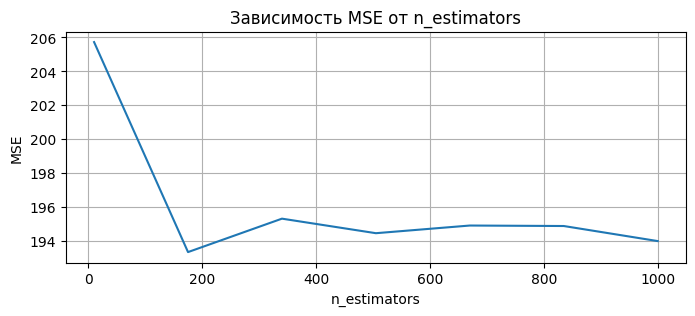

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.54s/it]


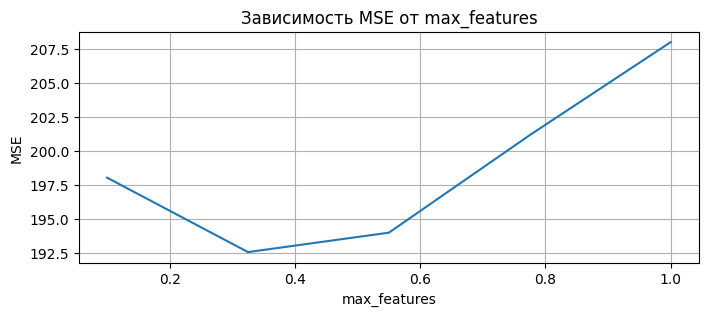

Пропуски в Wind_dir : 1
Пропуски в Wind_speed : 1


,Train,CV,Test
"2019-01-01 — 2023-03-22 {'max_features': 0.55, 'n_estimators': 835}",,,
MSE,29.52,300.74,44.37
MAE,3.10,9.67,5.49
MAPE,0.19,0.58,0.45
R2,0.97,0.69,0.54


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:45<00:00,  6.57s/it]


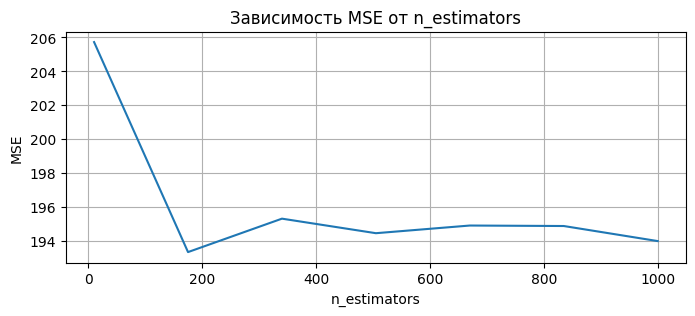

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:29<00:00,  5.87s/it]


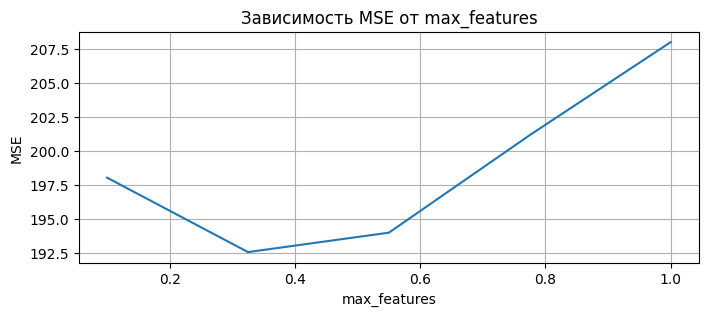

Пропуски в Wind_dir : 1
Пропуски в Wind_speed : 1


,Train,CV,Test
"2019-01-01 — 2023-03-22 {'max_features': 0.55, 'n_estimators': 835}",,,
MSE,29.52,300.74,55.22
MAE,3.10,9.67,5.64
MAPE,0.19,0.58,0.77
R2,0.97,0.69,-0.13


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:14<00:00,  2.06s/it]


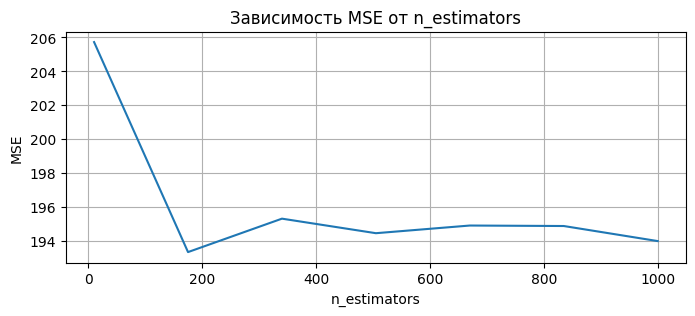

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.58s/it]


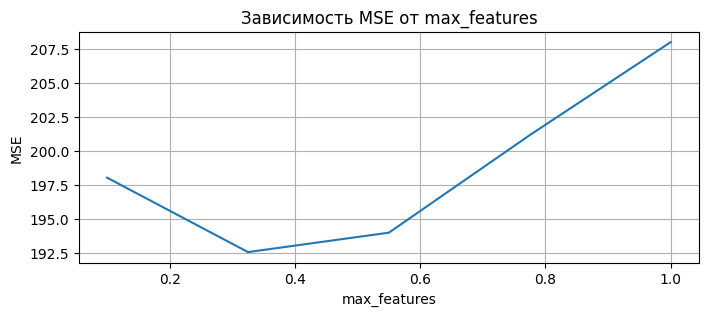

Пропуски в Wind_dir : 1
Пропуски в Wind_speed : 1


,Train,CV,Test
"2019-01-01 — 2023-03-22 {'max_features': 0.55, 'n_estimators': 835}",,,
MSE,29.52,300.74,30.23
MAE,3.10,9.67,4.55
MAPE,0.19,0.58,0.64
R2,0.97,0.69,0.32


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:14<00:00,  2.06s/it]


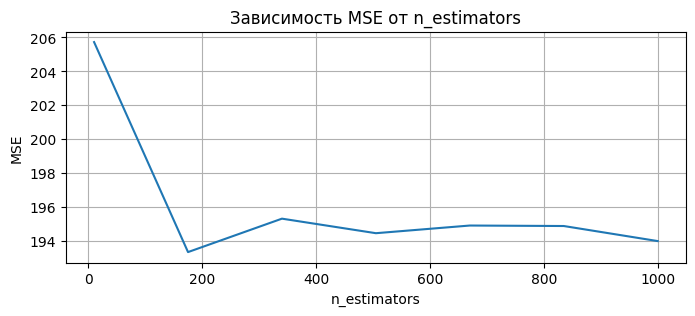

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.28s/it]


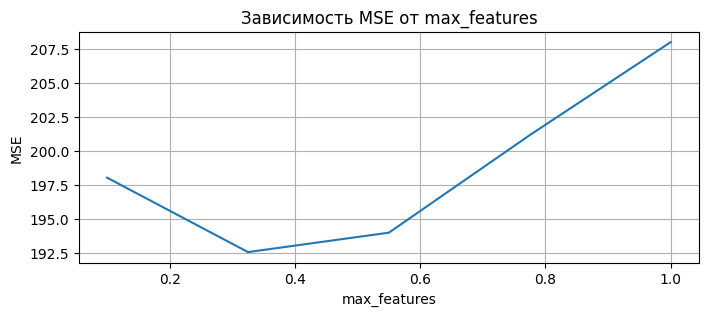

In [22]:
# Срез данных от begin до end
begin, end = '2019-01-01', '2023-04-06'

for season in ['winters', 'springs', 'summers', 'autumns']:
    ModelProcessing(model, sensor, fill, district, begin, end, seasonModel = '',  season_test = season, params = params, gridSearch = True, paramDependencies = ['n_estimators',  'max_features'], plotRes = False, featImp = False)#, savePath = 'Results/Results RF large periods.xlsx')

## Сезонные модели

Пропуски в Wind_dir : 1
Пропуски в Wind_speed : 1


,Train,CV,Test
"2019-01-01 — 2023-03-22 {'max_features': 0.55, 'n_estimators': 175}",,,
MSE,78.56,735.42,380.14
MAE,5.93,18.38,15.08
MAPE,0.18,0.54,0.47
R2,0.96,0.64,0.71


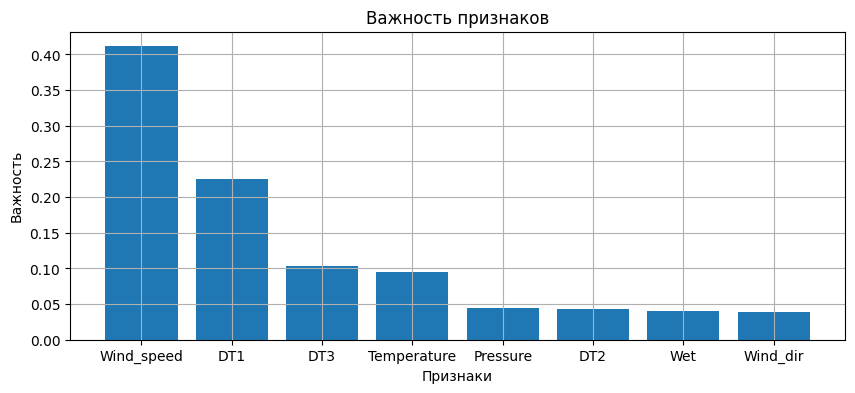

Пропуски в Wind_dir : 1
Пропуски в Wind_speed : 1


,Train,CV,Test
"2019-01-01 — 2023-03-22 {'max_features': 0.55, 'n_estimators': 670}",,,
MSE,5.90,51.68,38.42
MAE,1.79,5.39,4.36
MAPE,0.15,0.44,0.37
R2,0.95,0.57,0.60


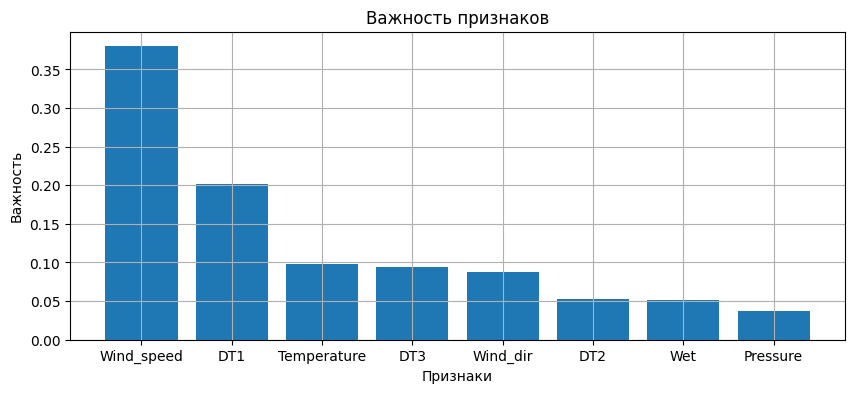

Пропуски в Wind_dir : 1
Пропуски в Wind_speed : 1


,Train,CV,Test
"2019-01-01 — 2023-03-22 {'max_features': 0.1, 'n_estimators': 1000}",,,
MSE,3.55,29.22,24.74
MAE,1.27,3.77,3.84
MAPE,0.17,0.52,0.48
R2,0.90,0.16,0.49


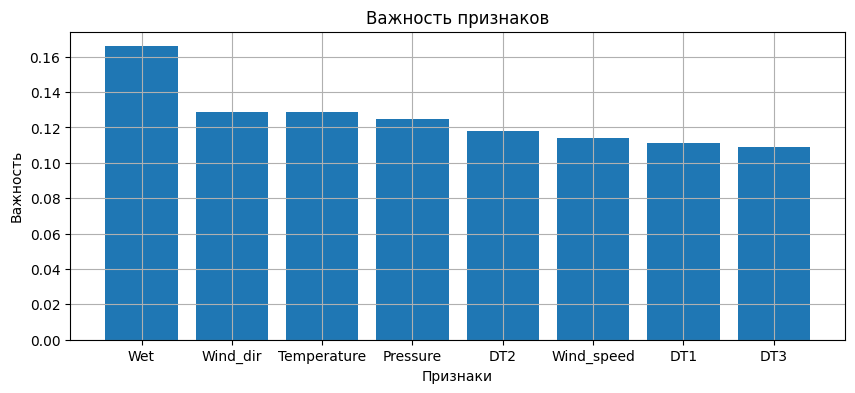

Пропуски в Wind_dir : 1
Пропуски в Wind_speed : 1


,Train,CV,Test
"2019-01-01 — 2023-03-22 {'max_features': 0.325, 'n_estimators': 1000}",,,
MSE,3.45,39.34,24.75
MAE,1.32,4.23,3.88
MAPE,0.17,0.51,0.59
R2,0.94,0.32,0.44


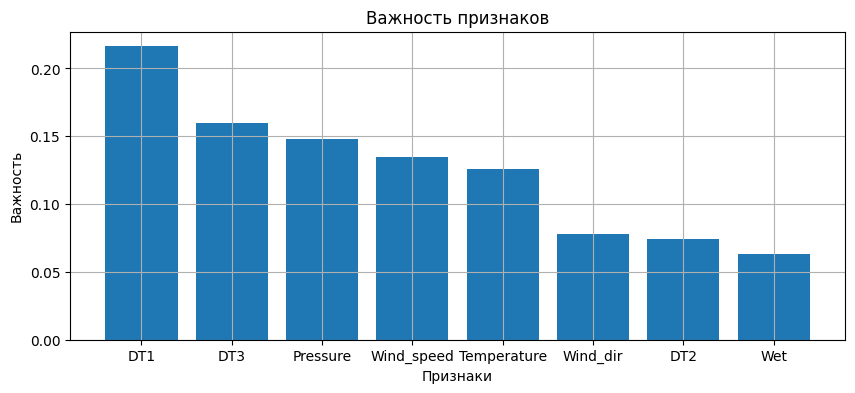

In [21]:
begin, end = '2019-01-01', '2023-04-06'

for season in ['winters', 'springs', 'summers', 'autumns']:
    ModelProcessing(model, sensor, fill, district, begin, end, seasonModel = season, season_test = season, params = params, gridSearch = True, paramDependencies = [], plotRes = False, featImp = True)#, savePath = 'Results/Results RF large periods.xlsx')